## Importing Libraries

In [1]:
# Standard libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
import copy
import requests
import time
import pickle
import glob
from pathlib import Path

# PyTorch and related libraries
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms as TF
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch import nn
import torchvision.transforms as T
import torchmetrics as TM
from torch.nn import Fold



# Transformers library
from transformers import get_scheduler

# Sklearn for metrics
from sklearn.metrics import jaccard_score, f1_score

# PIL for image processing
from PIL import Image

# Visualization libraries
import pandas as pd
import matplotlib.pyplot as plt

# Additional utilities
from typing import Sequence
import random
from dataclasses import dataclass
import dataclasses


In [2]:
# Import necessary modules from the PIL library
from PIL import Image, ImageFile

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set constant values for image size and batch size
IMG_SIZE = 256
BATCH_SIZE = 8

In [3]:
class AudioDenoisingDataset(Dataset):
    """Custom dataset for audio denoising task.

    Args:
        images_dir (str): Directory containing input images.
        masks_dir (str): Directory containing corresponding masks.
        transform (callable, optional): Optional transform to be applied on the input images.
    """

    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = [img for img in os.listdir(images_dir) if img.endswith('.png')]
        self.masks = [mask.replace('.png', '.png') for mask in self.images]

    def __len__(self):
        """Get the total number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """Get a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the input image and its corresponding mask.
        """
        image_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        # Convert mask to binary format with 0 and 1 values
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)

        # Convert to PIL Image for consistency in transforms
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)

        # Resize the mask to the desired image size
        mask = resize(mask, size=[IMG_SIZE, IMG_SIZE], interpolation=Image.Resampling.NEAREST)
        mask = TF.functional.to_tensor(mask)
        mask = (mask > 0).long()  # Threshold back to binary and convert to LongTensor

        return image, mask

In [4]:
# Define the appropriate transformations
transform = TF.Compose([
    TF.Resize((IMG_SIZE, IMG_SIZE)),
    # Uncomment the following lines if normalization is needed
    # TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    TF.ToTensor()
])

# Define the dataset paths
# Train part
train_images_dir = 'dataset/Train/Images'
train_masks_dir = 'dataset/Train/Masks'

# Validation part
valid_images_dir = 'dataset/Valid/Images'
valid_masks_dir = 'dataset/Valid/Masks'

# Test part
test_images_dir = 'dataset/Test/Images'
test_masks_dir = 'dataset/Test/Masks'

# Create the datasets
train_dataset = AudioDenoisingDataset(images_dir=train_images_dir,
                                      masks_dir=train_masks_dir,
                                      transform=transform)

valid_dataset = AudioDenoisingDataset(images_dir=valid_images_dir,
                                      masks_dir=valid_masks_dir,
                                      transform=transform)

test_dataset = AudioDenoisingDataset(images_dir=test_images_dir,
                                     masks_dir=test_masks_dir,
                                     transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
def F1_score(preds, labels, num_classes):
    """Calculate the mean F1 score for multiple classes.

    Args:
        preds (torch.Tensor): Predicted labels (logits) from the model.
        labels (torch.Tensor): Ground truth labels.
        num_classes (int): Number of classes in the segmentation task.

    Returns:
        float: Mean F1 score across all classes.
    """
    # Flatten predictions and labels
    preds_flat = preds.view(-1)
    labels_flat = labels.view(-1)

    # Calculate the F1 score for each class
    dice_scores = []
    for i in range(num_classes):
        class_preds = (preds_flat == i)
        class_labels = (labels_flat == i)

        # Calculate F1 score for each class
        dice = f1_score(class_labels.cpu().numpy(), class_preds.cpu().numpy(), labels=[True], average='binary')
        dice_scores.append(dice)

    # Return the mean F1 score
    return np.mean(dice_scores)


In [6]:
def dice_score_per_class(preds, labels, num_classes):
    """Calculate the Dice score for each class.

    Args:
        preds (np.ndarray): Predicted labels from the model.
        labels (np.ndarray): Ground truth labels.
        num_classes (int): Number of classes.

    Returns:
        np.ndarray: Dice score for each class.
    """
    dice_scores = []
    for i in range(num_classes):
        class_preds = (preds == i)
        class_labels = (labels == i)

        # Calculate Dice score for each class
        intersection = np.logical_and(class_labels.cpu().numpy().flatten(), class_preds.cpu().numpy().flatten()).sum()
        union = np.logical_or(class_labels.cpu().numpy().flatten(), class_preds.cpu().numpy().flatten()).sum()
        dice = (2 * intersection) / (union + intersection + 1e-8)  # Add epsilon to avoid division by zero
        dice_scores.append(dice)

    return np.array(dice_scores)


def dice_score(preds, labels, num_classes):
    """Calculate the mean Dice score for multiple classes.

    Args:
        preds (np.ndarray): Predicted labels from the model.
        labels (np.ndarray): Ground truth labels.
        num_classes (int): Number of classes.

    Returns:
        float: Mean Dice score across all classes.
    """
    # Calculate Dice score for each class
    dice_scores = dice_score_per_class(preds, labels, num_classes)

    # Return the mean Dice score
    return np.mean(dice_scores)


# def mean_iou(preds, labels, num_classes):
#     """Calculate the mean Intersection over Union (IoU) for multiple classes.

#     Args:
#         preds (torch.Tensor): Predicted labels (logits) from the model.
#         labels (torch.Tensor): Ground truth labels.
#         num_classes (int): Number of classes in the segmentation task.

#     Returns:
#         float: Mean IoU across all classes.
#     """
#     # Flatten predictions and labels
#     preds_flat = preds.view(-1)
#     labels_flat = labels.view(-1)

#     # Check that the number of elements in the flattened predictions
#     # and labels are equal
#     if preds_flat.shape[0] != labels_flat.shape[0]:
#         raise ValueError(f"Predictions and labels have mismatched shapes: "
#                          f"{preds_flat.shape} vs {labels_flat.shape}")

#     # Calculate the Jaccard score for each class
#     iou = jaccard_score(labels_flat.cpu().numpy(), preds_flat.cpu().numpy(),
#                         average=None, labels=range(num_classes))

#     # Return the mean IoU
#     return np.mean(iou)


In [7]:
import numpy as np

def iou_score_per_class(preds, labels, num_classes):
    """Calculate the Intersection over Union (IoU) score for each class.

    Args:
        preds (np.ndarray): Predicted labels from the model.
        labels (np.ndarray): Ground truth labels.
        num_classes (int): Number of classes.

    Returns:
        np.ndarray: IoU score for each class.
    """
    iou_scores = []
    for i in range(num_classes):
        class_preds = (preds == i)
        class_labels = (labels == i)

        # Calculate IoU score for each class
        intersection = np.logical_and(class_labels.cpu().numpy().flatten(), class_preds.cpu().numpy().flatten()).sum()
        union = np.logical_or(class_labels.cpu().numpy().flatten(), class_preds.cpu().numpy().flatten()).sum()
        iou = (intersection) / (union + 1e-8)  # Add epsilon to avoid division by zero
        iou_scores.append(iou)

    return np.array(iou_scores)


def mean_iou(preds, labels, num_classes):
    """Calculate the mean Intersection over Union (IoU) for multiple classes.

    Args:
        preds (np.ndarray): Predicted labels from the model.
        labels (np.ndarray): Ground truth labels.
        num_classes (int): Number of classes.

    Returns:
        float: Mean IoU across all classes.
    """
    # Calculate IoU score for each class
    iou_scores = iou_score_per_class(preds, labels, num_classes)

    # Return the mean IoU
    return np.mean(iou_scores)


# Block 12

In [8]:
@dataclasses.dataclass
class VisionTransformerArgs:
    """Data class to hold arguments for Vision Transformer model."""
    embed_size: int = IMG_SIZE
    image_size: int = IMG_SIZE
    patch_size: int = 16
    num_heads: int = 16
    dropout: float = 0.2
    in_channels: int = 3
    out_channels: int = 3
    num_blocks: int = 12

class ImageToPatches(nn.Module):
    """Converts an image into patches using unfolding."""
    def __init__(self, image_size, patch_size):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Ensure input has 4 dimensions (B, C, H, W)
        assert len(x.size()) == 4
        y = self.unfold(x)
        y = y.permute(0, 2, 1)
        return y

class PatchEmbedding(nn.Module):
    """Embeds patches into a lower-dimensional space."""
    def __init__(self, in_channels, embed_size):
        super().__init__()
        self.in_channels = in_channels
        self.embed_size = embed_size
        self.embed_layer = nn.Linear(in_features=in_channels, out_features=embed_size)

    def forward(self, x):
        # Ensure input has 3 dimensions (B, T, C)
        assert len(x.size()) == 3
        B, T, C = x.size()
        x = self.embed_layer(x)
        return x

class VisionTransformerInput(nn.Module):
    """Handles the input embedding for the Vision Transformer."""
    def __init__(self, image_size, patch_size, in_channels, embed_size):
        super().__init__()
        self.i2p = ImageToPatches(image_size, patch_size)
        self.pe = PatchEmbedding(patch_size * patch_size * in_channels, embed_size)
        num_patches = (image_size // patch_size) ** 2
        self.position_embed = nn.Parameter(torch.randn(num_patches, embed_size))

    def forward(self, x):
        x = self.i2p(x)
        x = self.pe(x)
        x = x + self.position_embed
        return x

class MultiLayerPerceptron(nn.Module):
    """A simple Multi-Layer Perceptron."""
    def __init__(self, embed_size, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.GELU(),
            nn.Linear(embed_size * 4, embed_size),
            nn.Dropout(p=dropout),
        )

    def forward(self, x):
        return self.layers(x)

class SelfAttentionEncoderBlock(nn.Module):
    """Encoder block with self-attention mechanism."""
    def __init__(self, embed_size, num_heads, dropout):
        super().__init__()
        self.embed_size = embed_size
        self.ln1 = nn.LayerNorm(embed_size)
        self.mha = nn.MultiheadAttention(embed_size, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_size)
        self.mlp = MultiLayerPerceptron(embed_size, dropout)

    def forward(self, x):
        y = self.ln1(x)
        x = x + self.mha(y, y, y, need_weights=False)[0]
        x = x + self.mlp(self.ln2(x))
        return x

class OutputProjection(nn.Module):
    """Projects the embeddings back to the original image size."""
    def __init__(self, image_size, patch_size, embed_size, output_dims):
        super().__init__()
        self.patch_size = patch_size
        self.output_dims = output_dims
        self.projection = nn.Linear(embed_size, patch_size * patch_size * output_dims)
        self.fold = Fold(output_size=(image_size, image_size), kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, T, C = x.shape
        x = self.projection(x)
        x = x.permute(0, 2, 1)
        x = self.fold(x)
        return x

class VisionTransformerForSegmentation(nn.Module):
    """Complete Vision Transformer for segmentation tasks."""
    def __init__(self, image_size, patch_size, in_channels, out_channels, embed_size, num_blocks, num_heads, dropout):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_size = embed_size
        self.num_blocks = num_blocks
        self.num_heads = num_heads
        self.dropout = dropout

        # Create a list of self-attention encoder blocks
        heads = [SelfAttentionEncoderBlock(embed_size, num_heads, dropout) for _ in range(num_blocks)]
        self.layers = nn.Sequential(
            nn.BatchNorm2d(num_features=in_channels),
            VisionTransformerInput(image_size, patch_size, in_channels, embed_size),
            nn.Sequential(*heads),
            OutputProjection(image_size, patch_size, embed_size, out_channels),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

def build_vision_transformer(args: VisionTransformerArgs):
    """Builds a Vision Transformer model based on the provided arguments.

    Args:
        args (VisionTransformerArgs): Arguments for the Vision Transformer.

    Returns:
        tuple: A tuple containing the Vision Transformer model, input shape, and output shape.
    """
    x = torch.randn(2, args.in_channels, args.image_size, args.image_size)
    vit = VisionTransformerForSegmentation(**dataclasses.asdict(args))
    y = vit(x)
    return vit, x.shape, y.shape

# Model usage:
vit_args = VisionTransformerArgs(embed_size=IMG_SIZE, image_size=IMG_SIZE)
vitvs_model, input_shape, output_shape = build_vision_transformer(vit_args)
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")
model_name = 'ViTVS_block_12_iou_80.pt'


Input Shape: torch.Size([2, 3, 256, 256]), Output Shape: torch.Size([2, 3, 256, 256])


In [9]:
# Clear the GPU memory cache to free up memory
torch.cuda.empty_cache()

# Display a summary of GPU memory usage
# The 'device' parameter can be specified to check memory for a specific GPU
# Set 'abbreviated' to True for a concise summary
# The summary includes details like allocated, reserved, and cached memory
memory_summary = torch.cuda.memory_summary(device=None, abbreviated=False)

# Print the memory summary
print(memory_summary)


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [10]:
# Check for CUDA acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = vit
model = vitvs_model
model.to(device)

VisionTransformerForSegmentation(
  (layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): VisionTransformerInput(
      (i2p): ImageToPatches(
        (unfold): Unfold(kernel_size=16, dilation=1, padding=0, stride=16)
      )
      (pe): PatchEmbedding(
        (embed_layer): Linear(in_features=768, out_features=256, bias=True)
      )
    )
    (2): Sequential(
      (0): SelfAttentionEncoderBlock(
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): MultiLayerPerceptron(
          (layers): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=1024, out_features=256, bias=Tr

In [11]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the learning rate scheduler
num_epochs = 100
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=2,
    num_training_steps=num_training_steps
)

# Lists to store metrics for plotting
train_losses = []
val_losses = []
mean_ious = []
mean_dices = []
mean_f1 = []

# Placeholder for best mean IoU and best model weights
best_iou = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    print("\n")
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=None, abbreviated=False)

    total_loss_train = 0
    num_batches = 0


    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for batch in train_iterator:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device).long()  

        # Remove the channel dimension from the masks tensor
        masks = masks.squeeze(1) 
        optimizer.zero_grad()

        # Pass inputs to the model
        outputs = model(images)
        
        softmax = nn.functional.log_softmax(outputs, dim=1)

        # Ensure the masks have the correct shape
        masks = masks.squeeze(1)  # Squeeze extra dimensions if present

        loss = nn.functional.nll_loss(softmax, masks.long())

        total_loss_train += loss.item()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        # outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)

        num_batches += 1
        
        train_iterator.set_postfix(loss=loss.item())
    train_loss = total_loss_train / num_batches
    train_losses.append(train_loss)
    
    # Evaluation loop for each epoch
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    total_f1 = 0
    num_batches = 0

    with torch.no_grad():
        valid_iterator = tqdm(valid_loader, desc="Validation", unit="batch")
        for batch in valid_iterator:
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device).long()

            # Remove the channel dimension from the masks tensor
            masks = masks.squeeze(1)

            # Pass inputs to the model
            outputs = model(images)

            softmax = nn.functional.log_softmax(outputs, dim=1)

            # Ensure the masks have the correct shape
            masks = masks.squeeze(1)  # Squeeze extra dimensions if present

            # Calculate the CrossEntropyLoss
            loss = nn.functional.nll_loss(softmax, masks.long())

            total_loss += loss.item()

            # Get the logits from the model and apply argmax to get the predictions
            # outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(outputs, dim=1)
            preds = torch.unsqueeze(preds, dim=1)

            preds = preds.view(-1)
            masks = masks.view(-1)

            # Compute IoU and Dice Score
            iou = mean_iou(preds, masks, 2)
            dice = dice_score(preds, masks, 2)
            f1 = F1_score(preds, masks, 2)
            total_iou += iou
            total_dice += dice
            total_f1 += f1
            num_batches += 1

            valid_iterator.set_postfix(loss=loss.item(), mean_iou=iou, dice_score=dice, f1_score=f1)
            

    epoch_loss = total_loss / num_batches
    epoch_iou = total_iou / num_batches
    epoch_dice = total_dice / num_batches
    epoch_f1 = total_f1 / num_batches
    
    val_losses.append(epoch_loss)
    mean_ious.append(epoch_iou)
    mean_dices.append(epoch_dice)
    mean_f1.append(epoch_f1)

    print(f"Validation => Mean Loss: {epoch_loss:.4f} | Mean IoU: {epoch_iou:.4f} | Mean Dice: {epoch_dice:.4f} | Mean F1 Score: {epoch_f1:.4f}")


    # Check for improvement and save the best model weights based on IoU
    if epoch_iou > best_iou:
        print(f"Validation IoU improved from {best_iou:.4f} to {epoch_iou:.4f}")
        best_iou = epoch_iou
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, model_name)

# After all epochs, load the best model weights - optional
model.load_state_dict(torch.load(model_name))
print("Loaded the best model weights!")

Epoch 1/100:   0%|          | 0/1250 [00:00<?, ?batch/s]

d:\program\ysz\anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Validation: 100%|██████████| 175/175 [02:42<00:00,  1.08batch/s, dice_score=0.825, f1_score=0.825, loss=0.0914, mean_iou=0.734]


Validation => Mean Loss: 0.0889 | Mean IoU: 0.7127 | Mean Dice: 0.8036 | Mean F1 Score: 0.8036
Validation IoU improved from 0.0000 to 0.7127




Validation: 100%|██████████| 175/175 [02:59<00:00,  1.02s/batch, dice_score=0.848, f1_score=0.848, loss=0.0815, mean_iou=0.76] 


Validation => Mean Loss: 0.0775 | Mean IoU: 0.7483 | Mean Dice: 0.8353 | Mean F1 Score: 0.8353
Validation IoU improved from 0.7127 to 0.7483




Validation: 100%|██████████| 175/175 [03:01<00:00,  1.04s/batch, dice_score=0.861, f1_score=0.861, loss=0.0733, mean_iou=0.777]


Validation => Mean Loss: 0.0731 | Mean IoU: 0.7580 | Mean Dice: 0.8432 | Mean F1 Score: 0.8432
Validation IoU improved from 0.7483 to 0.7580




Validation: 100%|██████████| 175/175 [03:08<00:00,  1.07s/batch, dice_score=0.858, f1_score=0.858, loss=0.0713, mean_iou=0.773]


Validation => Mean Loss: 0.0714 | Mean IoU: 0.7565 | Mean Dice: 0.8419 | Mean F1 Score: 0.8419




Validation: 100%|██████████| 175/175 [03:04<00:00,  1.06s/batch, dice_score=0.866, f1_score=0.866, loss=0.0695, mean_iou=0.783]


Validation => Mean Loss: 0.0726 | Mean IoU: 0.7526 | Mean Dice: 0.8385 | Mean F1 Score: 0.8385




Validation: 100%|██████████| 175/175 [03:01<00:00,  1.04s/batch, dice_score=0.886, f1_score=0.886, loss=0.0612, mean_iou=0.811]


Validation => Mean Loss: 0.0672 | Mean IoU: 0.7757 | Mean Dice: 0.8576 | Mean F1 Score: 0.8576
Validation IoU improved from 0.7580 to 0.7757




Validation: 100%|██████████| 175/175 [03:00<00:00,  1.03s/batch, dice_score=0.89, f1_score=0.89, loss=0.0571, mean_iou=0.816]  


Validation => Mean Loss: 0.0651 | Mean IoU: 0.7791 | Mean Dice: 0.8602 | Mean F1 Score: 0.8602
Validation IoU improved from 0.7757 to 0.7791




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.886, f1_score=0.886, loss=0.0588, mean_iou=0.811]


Validation => Mean Loss: 0.0637 | Mean IoU: 0.7859 | Mean Dice: 0.8657 | Mean F1 Score: 0.8657
Validation IoU improved from 0.7791 to 0.7859




Validation: 100%|██████████| 175/175 [02:26<00:00,  1.19batch/s, dice_score=0.897, f1_score=0.897, loss=0.0553, mean_iou=0.826]


Validation => Mean Loss: 0.0636 | Mean IoU: 0.7842 | Mean Dice: 0.8641 | Mean F1 Score: 0.8641




Validation: 100%|██████████| 175/175 [02:26<00:00,  1.20batch/s, dice_score=0.89, f1_score=0.89, loss=0.0556, mean_iou=0.816]  


Validation => Mean Loss: 0.0650 | Mean IoU: 0.7739 | Mean Dice: 0.8554 | Mean F1 Score: 0.8554




Validation: 100%|██████████| 175/175 [02:26<00:00,  1.19batch/s, dice_score=0.896, f1_score=0.896, loss=0.0552, mean_iou=0.825]


Validation => Mean Loss: 0.0624 | Mean IoU: 0.7876 | Mean Dice: 0.8666 | Mean F1 Score: 0.8666
Validation IoU improved from 0.7859 to 0.7876




Validation: 100%|██████████| 175/175 [02:25<00:00,  1.20batch/s, dice_score=0.896, f1_score=0.896, loss=0.0556, mean_iou=0.825]


Validation => Mean Loss: 0.0624 | Mean IoU: 0.7914 | Mean Dice: 0.8695 | Mean F1 Score: 0.8695
Validation IoU improved from 0.7876 to 0.7914




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.904, f1_score=0.904, loss=0.0525, mean_iou=0.836]


Validation => Mean Loss: 0.0623 | Mean IoU: 0.7921 | Mean Dice: 0.8701 | Mean F1 Score: 0.8701
Validation IoU improved from 0.7914 to 0.7921




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.02batch/s, dice_score=0.89, f1_score=0.89, loss=0.0584, mean_iou=0.816]  


Validation => Mean Loss: 0.0625 | Mean IoU: 0.7941 | Mean Dice: 0.8717 | Mean F1 Score: 0.8717
Validation IoU improved from 0.7921 to 0.7941




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.888, f1_score=0.888, loss=0.0562, mean_iou=0.814]


Validation => Mean Loss: 0.0623 | Mean IoU: 0.7920 | Mean Dice: 0.8702 | Mean F1 Score: 0.8702




Validation: 100%|██████████| 175/175 [02:24<00:00,  1.21batch/s, dice_score=0.881, f1_score=0.881, loss=0.06, mean_iou=0.804]  


Validation => Mean Loss: 0.0634 | Mean IoU: 0.7875 | Mean Dice: 0.8667 | Mean F1 Score: 0.8667




Validation: 100%|██████████| 175/175 [02:25<00:00,  1.21batch/s, dice_score=0.903, f1_score=0.903, loss=0.0525, mean_iou=0.835]


Validation => Mean Loss: 0.0608 | Mean IoU: 0.7981 | Mean Dice: 0.8746 | Mean F1 Score: 0.8746
Validation IoU improved from 0.7941 to 0.7981




Validation: 100%|██████████| 175/175 [02:25<00:00,  1.20batch/s, dice_score=0.905, f1_score=0.905, loss=0.0554, mean_iou=0.837]


Validation => Mean Loss: 0.0615 | Mean IoU: 0.7987 | Mean Dice: 0.8755 | Mean F1 Score: 0.8755
Validation IoU improved from 0.7981 to 0.7987




Validation: 100%|██████████| 175/175 [02:30<00:00,  1.16batch/s, dice_score=0.898, f1_score=0.898, loss=0.0542, mean_iou=0.827]


Validation => Mean Loss: 0.0610 | Mean IoU: 0.7930 | Mean Dice: 0.8704 | Mean F1 Score: 0.8704




Validation: 100%|██████████| 175/175 [02:54<00:00,  1.00batch/s, dice_score=0.897, f1_score=0.897, loss=0.0533, mean_iou=0.826] 


Validation => Mean Loss: 0.0622 | Mean IoU: 0.7964 | Mean Dice: 0.8731 | Mean F1 Score: 0.8731




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.906, f1_score=0.906, loss=0.0513, mean_iou=0.839]


Validation => Mean Loss: 0.0611 | Mean IoU: 0.7959 | Mean Dice: 0.8727 | Mean F1 Score: 0.8727




Validation: 100%|██████████| 175/175 [02:52<00:00,  1.01batch/s, dice_score=0.903, f1_score=0.903, loss=0.0499, mean_iou=0.834] 


Validation => Mean Loss: 0.0622 | Mean IoU: 0.7922 | Mean Dice: 0.8697 | Mean F1 Score: 0.8697




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.89, f1_score=0.89, loss=0.0534, mean_iou=0.816]  


Validation => Mean Loss: 0.0620 | Mean IoU: 0.7896 | Mean Dice: 0.8678 | Mean F1 Score: 0.8678




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.907, f1_score=0.907, loss=0.0495, mean_iou=0.84] 


Validation => Mean Loss: 0.0608 | Mean IoU: 0.7976 | Mean Dice: 0.8741 | Mean F1 Score: 0.8741




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.904, f1_score=0.904, loss=0.0535, mean_iou=0.836]


Validation => Mean Loss: 0.0608 | Mean IoU: 0.8026 | Mean Dice: 0.8784 | Mean F1 Score: 0.8784
Validation IoU improved from 0.7987 to 0.8026




Validation: 100%|██████████| 175/175 [02:59<00:00,  1.02s/batch, dice_score=0.908, f1_score=0.908, loss=0.0497, mean_iou=0.841] 


Validation => Mean Loss: 0.0595 | Mean IoU: 0.8030 | Mean Dice: 0.8785 | Mean F1 Score: 0.8785
Validation IoU improved from 0.8026 to 0.8030




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.909, f1_score=0.909, loss=0.0479, mean_iou=0.843]


Validation => Mean Loss: 0.0610 | Mean IoU: 0.8026 | Mean Dice: 0.8780 | Mean F1 Score: 0.8780




Validation: 100%|██████████| 175/175 [02:34<00:00,  1.14batch/s, dice_score=0.905, f1_score=0.905, loss=0.0507, mean_iou=0.837]


Validation => Mean Loss: 0.0597 | Mean IoU: 0.8040 | Mean Dice: 0.8792 | Mean F1 Score: 0.8792
Validation IoU improved from 0.8030 to 0.8040




Validation: 100%|██████████| 175/175 [02:52<00:00,  1.01batch/s, dice_score=0.905, f1_score=0.905, loss=0.0494, mean_iou=0.837]


Validation => Mean Loss: 0.0602 | Mean IoU: 0.8029 | Mean Dice: 0.8782 | Mean F1 Score: 0.8782




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.903, f1_score=0.903, loss=0.05, mean_iou=0.834]   


Validation => Mean Loss: 0.0612 | Mean IoU: 0.8022 | Mean Dice: 0.8773 | Mean F1 Score: 0.8773




Validation: 100%|██████████| 175/175 [02:24<00:00,  1.21batch/s, dice_score=0.904, f1_score=0.904, loss=0.0502, mean_iou=0.835] 


Validation => Mean Loss: 0.0611 | Mean IoU: 0.7998 | Mean Dice: 0.8755 | Mean F1 Score: 0.8755




Validation: 100%|██████████| 175/175 [02:24<00:00,  1.22batch/s, dice_score=0.909, f1_score=0.909, loss=0.0475, mean_iou=0.844] 


Validation => Mean Loss: 0.0607 | Mean IoU: 0.8021 | Mean Dice: 0.8777 | Mean F1 Score: 0.8777




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.906, f1_score=0.906, loss=0.0504, mean_iou=0.839] 


Validation => Mean Loss: 0.0604 | Mean IoU: 0.8061 | Mean Dice: 0.8809 | Mean F1 Score: 0.8809
Validation IoU improved from 0.8040 to 0.8061




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.901, f1_score=0.901, loss=0.0512, mean_iou=0.831]


Validation => Mean Loss: 0.0596 | Mean IoU: 0.8058 | Mean Dice: 0.8804 | Mean F1 Score: 0.8804




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.04batch/s, dice_score=0.909, f1_score=0.909, loss=0.0482, mean_iou=0.843] 


Validation => Mean Loss: 0.0602 | Mean IoU: 0.8066 | Mean Dice: 0.8809 | Mean F1 Score: 0.8809
Validation IoU improved from 0.8061 to 0.8066




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.9, f1_score=0.9, loss=0.0519, mean_iou=0.83]      


Validation => Mean Loss: 0.0608 | Mean IoU: 0.8022 | Mean Dice: 0.8774 | Mean F1 Score: 0.8774




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.897, f1_score=0.897, loss=0.0534, mean_iou=0.826]


Validation => Mean Loss: 0.0625 | Mean IoU: 0.8022 | Mean Dice: 0.8774 | Mean F1 Score: 0.8774




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.904, f1_score=0.904, loss=0.0507, mean_iou=0.835]


Validation => Mean Loss: 0.0604 | Mean IoU: 0.8054 | Mean Dice: 0.8800 | Mean F1 Score: 0.8800




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.905, f1_score=0.905, loss=0.0503, mean_iou=0.837] 


Validation => Mean Loss: 0.0609 | Mean IoU: 0.8036 | Mean Dice: 0.8788 | Mean F1 Score: 0.8788




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.02batch/s, dice_score=0.902, f1_score=0.902, loss=0.0503, mean_iou=0.834] 


Validation => Mean Loss: 0.0608 | Mean IoU: 0.8042 | Mean Dice: 0.8791 | Mean F1 Score: 0.8791




Validation: 100%|██████████| 175/175 [02:59<00:00,  1.02s/batch, dice_score=0.905, f1_score=0.905, loss=0.0508, mean_iou=0.837]


Validation => Mean Loss: 0.0610 | Mean IoU: 0.8062 | Mean Dice: 0.8808 | Mean F1 Score: 0.8808




Validation: 100%|██████████| 175/175 [02:57<00:00,  1.02s/batch, dice_score=0.91, f1_score=0.91, loss=0.048, mean_iou=0.844]    


Validation => Mean Loss: 0.0608 | Mean IoU: 0.8058 | Mean Dice: 0.8804 | Mean F1 Score: 0.8804




Validation: 100%|██████████| 175/175 [02:52<00:00,  1.01batch/s, dice_score=0.902, f1_score=0.902, loss=0.0525, mean_iou=0.833]


Validation => Mean Loss: 0.0615 | Mean IoU: 0.8070 | Mean Dice: 0.8811 | Mean F1 Score: 0.8811
Validation IoU improved from 0.8066 to 0.8070




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.91, f1_score=0.91, loss=0.0482, mean_iou=0.845]   


Validation => Mean Loss: 0.0609 | Mean IoU: 0.8086 | Mean Dice: 0.8826 | Mean F1 Score: 0.8826
Validation IoU improved from 0.8070 to 0.8086




Validation: 100%|██████████| 175/175 [02:52<00:00,  1.02batch/s, dice_score=0.909, f1_score=0.909, loss=0.0478, mean_iou=0.844]


Validation => Mean Loss: 0.0601 | Mean IoU: 0.8066 | Mean Dice: 0.8810 | Mean F1 Score: 0.8810




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.903, f1_score=0.903, loss=0.0519, mean_iou=0.834] 


Validation => Mean Loss: 0.0617 | Mean IoU: 0.8084 | Mean Dice: 0.8822 | Mean F1 Score: 0.8822




Validation: 100%|██████████| 175/175 [02:35<00:00,  1.13batch/s, dice_score=0.908, f1_score=0.908, loss=0.0481, mean_iou=0.842] 


Validation => Mean Loss: 0.0609 | Mean IoU: 0.8076 | Mean Dice: 0.8817 | Mean F1 Score: 0.8817




Validation: 100%|██████████| 175/175 [02:57<00:00,  1.01s/batch, dice_score=0.906, f1_score=0.906, loss=0.0497, mean_iou=0.839]


Validation => Mean Loss: 0.0610 | Mean IoU: 0.8076 | Mean Dice: 0.8817 | Mean F1 Score: 0.8817




Validation: 100%|██████████| 175/175 [02:53<00:00,  1.01batch/s, dice_score=0.907, f1_score=0.907, loss=0.0484, mean_iou=0.841] 


Validation => Mean Loss: 0.0612 | Mean IoU: 0.8086 | Mean Dice: 0.8824 | Mean F1 Score: 0.8824




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.912, f1_score=0.912, loss=0.0481, mean_iou=0.847]


Validation => Mean Loss: 0.0618 | Mean IoU: 0.8090 | Mean Dice: 0.8828 | Mean F1 Score: 0.8828
Validation IoU improved from 0.8086 to 0.8090




Validation: 100%|██████████| 175/175 [02:48<00:00,  1.04batch/s, dice_score=0.904, f1_score=0.904, loss=0.0524, mean_iou=0.836] 


Validation => Mean Loss: 0.0628 | Mean IoU: 0.8055 | Mean Dice: 0.8799 | Mean F1 Score: 0.8799




Validation: 100%|██████████| 175/175 [02:34<00:00,  1.13batch/s, dice_score=0.905, f1_score=0.905, loss=0.0498, mean_iou=0.838]


Validation => Mean Loss: 0.0617 | Mean IoU: 0.8050 | Mean Dice: 0.8795 | Mean F1 Score: 0.8795




Validation: 100%|██████████| 175/175 [02:52<00:00,  1.01batch/s, dice_score=0.907, f1_score=0.907, loss=0.0488, mean_iou=0.84]  


Validation => Mean Loss: 0.0618 | Mean IoU: 0.8072 | Mean Dice: 0.8814 | Mean F1 Score: 0.8814




Validation: 100%|██████████| 175/175 [02:35<00:00,  1.13batch/s, dice_score=0.905, f1_score=0.905, loss=0.0503, mean_iou=0.838] 


Validation => Mean Loss: 0.0621 | Mean IoU: 0.8080 | Mean Dice: 0.8820 | Mean F1 Score: 0.8820




Validation: 100%|██████████| 175/175 [02:34<00:00,  1.13batch/s, dice_score=0.908, f1_score=0.908, loss=0.0492, mean_iou=0.842]


Validation => Mean Loss: 0.0623 | Mean IoU: 0.8051 | Mean Dice: 0.8798 | Mean F1 Score: 0.8798




Validation: 100%|██████████| 175/175 [02:34<00:00,  1.13batch/s, dice_score=0.911, f1_score=0.911, loss=0.0481, mean_iou=0.847]


Validation => Mean Loss: 0.0615 | Mean IoU: 0.8082 | Mean Dice: 0.8821 | Mean F1 Score: 0.8821




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.904, f1_score=0.904, loss=0.0514, mean_iou=0.836] 


Validation => Mean Loss: 0.0619 | Mean IoU: 0.8087 | Mean Dice: 0.8824 | Mean F1 Score: 0.8824




Validation: 100%|██████████| 175/175 [02:36<00:00,  1.12batch/s, dice_score=0.909, f1_score=0.909, loss=0.0485, mean_iou=0.843] 


Validation => Mean Loss: 0.0620 | Mean IoU: 0.8087 | Mean Dice: 0.8825 | Mean F1 Score: 0.8825




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.907, f1_score=0.907, loss=0.0499, mean_iou=0.841] 


Validation => Mean Loss: 0.0621 | Mean IoU: 0.8085 | Mean Dice: 0.8824 | Mean F1 Score: 0.8824




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.02batch/s, dice_score=0.908, f1_score=0.908, loss=0.0492, mean_iou=0.842] 


Validation => Mean Loss: 0.0624 | Mean IoU: 0.8094 | Mean Dice: 0.8831 | Mean F1 Score: 0.8831
Validation IoU improved from 0.8090 to 0.8094




Validation: 100%|██████████| 175/175 [02:44<00:00,  1.06batch/s, dice_score=0.906, f1_score=0.906, loss=0.0505, mean_iou=0.839]


Validation => Mean Loss: 0.0625 | Mean IoU: 0.8076 | Mean Dice: 0.8816 | Mean F1 Score: 0.8816




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.903, f1_score=0.903, loss=0.0533, mean_iou=0.834]


Validation => Mean Loss: 0.0634 | Mean IoU: 0.8080 | Mean Dice: 0.8819 | Mean F1 Score: 0.8819




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.902, f1_score=0.902, loss=0.0553, mean_iou=0.833]


Validation => Mean Loss: 0.0640 | Mean IoU: 0.8074 | Mean Dice: 0.8814 | Mean F1 Score: 0.8814




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.04batch/s, dice_score=0.909, f1_score=0.909, loss=0.0498, mean_iou=0.843]


Validation => Mean Loss: 0.0634 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.908, f1_score=0.908, loss=0.0525, mean_iou=0.841]


Validation => Mean Loss: 0.0636 | Mean IoU: 0.8083 | Mean Dice: 0.8821 | Mean F1 Score: 0.8821




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.04batch/s, dice_score=0.905, f1_score=0.905, loss=0.052, mean_iou=0.838] 


Validation => Mean Loss: 0.0632 | Mean IoU: 0.8094 | Mean Dice: 0.8831 | Mean F1 Score: 0.8831
Validation IoU improved from 0.8094 to 0.8094




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.908, f1_score=0.908, loss=0.0515, mean_iou=0.841] 


Validation => Mean Loss: 0.0634 | Mean IoU: 0.8086 | Mean Dice: 0.8824 | Mean F1 Score: 0.8824




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.904, f1_score=0.904, loss=0.0517, mean_iou=0.836] 


Validation => Mean Loss: 0.0632 | Mean IoU: 0.8081 | Mean Dice: 0.8820 | Mean F1 Score: 0.8820




Validation: 100%|██████████| 175/175 [02:48<00:00,  1.04batch/s, dice_score=0.904, f1_score=0.904, loss=0.0533, mean_iou=0.836]


Validation => Mean Loss: 0.0640 | Mean IoU: 0.8091 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.908, f1_score=0.908, loss=0.0506, mean_iou=0.841]


Validation => Mean Loss: 0.0643 | Mean IoU: 0.8086 | Mean Dice: 0.8824 | Mean F1 Score: 0.8824




Validation: 100%|██████████| 175/175 [02:56<00:00,  1.01s/batch, dice_score=0.905, f1_score=0.905, loss=0.0533, mean_iou=0.837] 


Validation => Mean Loss: 0.0652 | Mean IoU: 0.8093 | Mean Dice: 0.8828 | Mean F1 Score: 0.8828




Validation: 100%|██████████| 175/175 [02:58<00:00,  1.02s/batch, dice_score=0.905, f1_score=0.905, loss=0.0528, mean_iou=0.837] 


Validation => Mean Loss: 0.0637 | Mean IoU: 0.8091 | Mean Dice: 0.8828 | Mean F1 Score: 0.8828




Validation: 100%|██████████| 175/175 [02:58<00:00,  1.02s/batch, dice_score=0.905, f1_score=0.905, loss=0.0518, mean_iou=0.837] 


Validation => Mean Loss: 0.0640 | Mean IoU: 0.8088 | Mean Dice: 0.8826 | Mean F1 Score: 0.8826




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.907, f1_score=0.907, loss=0.0512, mean_iou=0.841] 


Validation => Mean Loss: 0.0646 | Mean IoU: 0.8086 | Mean Dice: 0.8825 | Mean F1 Score: 0.8825




Validation: 100%|██████████| 175/175 [02:44<00:00,  1.06batch/s, dice_score=0.909, f1_score=0.909, loss=0.0505, mean_iou=0.843]


Validation => Mean Loss: 0.0657 | Mean IoU: 0.8092 | Mean Dice: 0.8828 | Mean F1 Score: 0.8828




Validation: 100%|██████████| 175/175 [02:53<00:00,  1.01batch/s, dice_score=0.906, f1_score=0.906, loss=0.0517, mean_iou=0.839] 


Validation => Mean Loss: 0.0644 | Mean IoU: 0.8082 | Mean Dice: 0.8821 | Mean F1 Score: 0.8821




Validation: 100%|██████████| 175/175 [02:58<00:00,  1.02s/batch, dice_score=0.905, f1_score=0.905, loss=0.0525, mean_iou=0.837] 


Validation => Mean Loss: 0.0654 | Mean IoU: 0.8084 | Mean Dice: 0.8821 | Mean F1 Score: 0.8821




Validation: 100%|██████████| 175/175 [02:58<00:00,  1.02s/batch, dice_score=0.905, f1_score=0.905, loss=0.0523, mean_iou=0.838] 


Validation => Mean Loss: 0.0653 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.904, f1_score=0.904, loss=0.0549, mean_iou=0.836] 


Validation => Mean Loss: 0.0657 | Mean IoU: 0.8082 | Mean Dice: 0.8820 | Mean F1 Score: 0.8820




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.904, f1_score=0.904, loss=0.0548, mean_iou=0.836]


Validation => Mean Loss: 0.0659 | Mean IoU: 0.8084 | Mean Dice: 0.8822 | Mean F1 Score: 0.8822




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.905, f1_score=0.905, loss=0.0543, mean_iou=0.838]


Validation => Mean Loss: 0.0659 | Mean IoU: 0.8092 | Mean Dice: 0.8828 | Mean F1 Score: 0.8828




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.906, f1_score=0.906, loss=0.0536, mean_iou=0.839] 


Validation => Mean Loss: 0.0656 | Mean IoU: 0.8095 | Mean Dice: 0.8830 | Mean F1 Score: 0.8830
Validation IoU improved from 0.8094 to 0.8095




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.906, f1_score=0.906, loss=0.0532, mean_iou=0.839] 


Validation => Mean Loss: 0.0660 | Mean IoU: 0.8088 | Mean Dice: 0.8824 | Mean F1 Score: 0.8824




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.905, f1_score=0.905, loss=0.0534, mean_iou=0.838]


Validation => Mean Loss: 0.0663 | Mean IoU: 0.8076 | Mean Dice: 0.8815 | Mean F1 Score: 0.8815




Validation: 100%|██████████| 175/175 [02:25<00:00,  1.20batch/s, dice_score=0.904, f1_score=0.904, loss=0.0551, mean_iou=0.836] 


Validation => Mean Loss: 0.0660 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:24<00:00,  1.21batch/s, dice_score=0.907, f1_score=0.907, loss=0.0525, mean_iou=0.84]  


Validation => Mean Loss: 0.0664 | Mean IoU: 0.8099 | Mean Dice: 0.8834 | Mean F1 Score: 0.8834
Validation IoU improved from 0.8095 to 0.8099




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.907, f1_score=0.907, loss=0.0526, mean_iou=0.84] 


Validation => Mean Loss: 0.0661 | Mean IoU: 0.8097 | Mean Dice: 0.8832 | Mean F1 Score: 0.8832




Validation: 100%|██████████| 175/175 [02:49<00:00,  1.03batch/s, dice_score=0.906, f1_score=0.906, loss=0.0541, mean_iou=0.838] 


Validation => Mean Loss: 0.0668 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:52<00:00,  1.02batch/s, dice_score=0.907, f1_score=0.907, loss=0.0519, mean_iou=0.84] 


Validation => Mean Loss: 0.0667 | Mean IoU: 0.8085 | Mean Dice: 0.8823 | Mean F1 Score: 0.8823




Validation: 100%|██████████| 175/175 [02:26<00:00,  1.20batch/s, dice_score=0.906, f1_score=0.906, loss=0.0531, mean_iou=0.839] 


Validation => Mean Loss: 0.0669 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.903, f1_score=0.903, loss=0.0557, mean_iou=0.835] 


Validation => Mean Loss: 0.0666 | Mean IoU: 0.8087 | Mean Dice: 0.8825 | Mean F1 Score: 0.8825




Validation: 100%|██████████| 175/175 [02:59<00:00,  1.03s/batch, dice_score=0.905, f1_score=0.905, loss=0.0536, mean_iou=0.838] 


Validation => Mean Loss: 0.0666 | Mean IoU: 0.8095 | Mean Dice: 0.8831 | Mean F1 Score: 0.8831




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.906, f1_score=0.906, loss=0.0536, mean_iou=0.838]


Validation => Mean Loss: 0.0665 | Mean IoU: 0.8095 | Mean Dice: 0.8831 | Mean F1 Score: 0.8831




Validation: 100%|██████████| 175/175 [03:00<00:00,  1.03s/batch, dice_score=0.906, f1_score=0.906, loss=0.0542, mean_iou=0.839] 


Validation => Mean Loss: 0.0671 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.905, f1_score=0.905, loss=0.0543, mean_iou=0.838]


Validation => Mean Loss: 0.0671 | Mean IoU: 0.8095 | Mean Dice: 0.8831 | Mean F1 Score: 0.8831




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.905, f1_score=0.905, loss=0.0548, mean_iou=0.837] 


Validation => Mean Loss: 0.0671 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.906, f1_score=0.906, loss=0.0539, mean_iou=0.838] 


Validation => Mean Loss: 0.0672 | Mean IoU: 0.8089 | Mean Dice: 0.8826 | Mean F1 Score: 0.8826




Validation: 100%|██████████| 175/175 [02:50<00:00,  1.03batch/s, dice_score=0.905, f1_score=0.905, loss=0.0545, mean_iou=0.837] 


Validation => Mean Loss: 0.0669 | Mean IoU: 0.8093 | Mean Dice: 0.8829 | Mean F1 Score: 0.8829




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.905, f1_score=0.905, loss=0.0545, mean_iou=0.837]


Validation => Mean Loss: 0.0670 | Mean IoU: 0.8093 | Mean Dice: 0.8829 | Mean F1 Score: 0.8829




Validation: 100%|██████████| 175/175 [02:51<00:00,  1.02batch/s, dice_score=0.906, f1_score=0.906, loss=0.0534, mean_iou=0.839] 

Validation => Mean Loss: 0.0672 | Mean IoU: 0.8090 | Mean Dice: 0.8827 | Mean F1 Score: 0.8827
Loaded the best model weights!


In [12]:
# model_name = "unet-6v_95.pt" 
model.load_state_dict(torch.load(model_name, map_location=torch.device("cpu")))
model.to(device)
model.eval()

VisionTransformerForSegmentation(
  (layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): VisionTransformerInput(
      (i2p): ImageToPatches(
        (unfold): Unfold(kernel_size=16, dilation=1, padding=0, stride=16)
      )
      (pe): PatchEmbedding(
        (embed_layer): Linear(in_features=768, out_features=256, bias=True)
      )
    )
    (2): Sequential(
      (0): SelfAttentionEncoderBlock(
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): MultiLayerPerceptron(
          (layers): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=1024, out_features=256, bias=Tr

Text(0.5, 0, 'epoch')

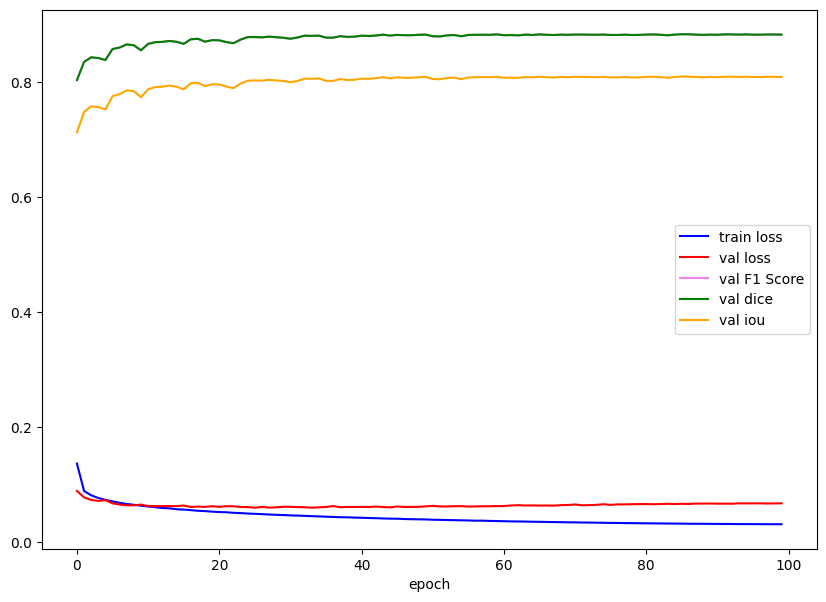

In [13]:
plt.figure(figsize=(10, 7))


# Plotting training and validation metrics
plt.plot(range(len(train_losses)), train_losses, "b", label="train loss")
plt.plot(range(len(val_losses)), val_losses, "r", label="val loss")
plt.plot(range(len(mean_f1)), mean_f1, "violet", label="val F1 Score")
plt.plot(range(len(mean_dices)), mean_dices, "g", label="val dice")
plt.plot(range(len(mean_ious)), mean_ious, "orange", label="val iou")


plt.legend()  # Adding legend
plt.xlabel("epoch")  # Labeling x-axis with 'epoch'

## Validation

In [14]:

# fValidation
# Evaluation loop for each epoch
model.eval()
total_loss = 0
total_iou = 0
total_dice = 0
total_f1 = 0
num_batches = 0


with torch.no_grad():
    valid_iterator = tqdm(valid_loader, desc="Validation", unit="batch")
    for batch in valid_iterator:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device).long()

        # Remove the channel dimension from the masks tensor
        masks = masks.squeeze(1)

        # Pass inputs to the model
        outputs = model(images)

        softmax = nn.functional.log_softmax(outputs, dim=1)

        # Ensure the masks have the correct shape
        masks = masks.squeeze(1)  # Squeeze extra dimensions if present

        # Calculate the CrossEntropyLoss
        loss = nn.functional.nll_loss(softmax, masks.long())

        total_loss += loss.item()

        # Get the logits from the model and apply argmax to get the predictions
        # outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)
        preds = torch.argmax(outputs, dim=1)
        preds = torch.unsqueeze(preds, dim=1)

        preds = preds.view(-1)
        masks = masks.view(-1)

        # Compute IoU and Dice Score
        iou = mean_iou(preds, masks, 2)
        dice = dice_score(preds, masks, 2)
        f1 = F1_score(preds, masks, 2)
        total_iou += iou
        total_dice += dice
        total_f1 += f1
        num_batches += 1

        valid_iterator.set_postfix(loss=loss.item(), mean_iou=iou, dice_score=dice, f1_score=f1)
        

epoch_loss = total_loss / num_batches
epoch_iou = total_iou / num_batches
epoch_dice = total_dice / num_batches
epoch_f1 = total_f1 / num_batches

print(f"Validation => Mean Loss: {epoch_loss:.4f} | Mean IoU: {epoch_iou:.4f} | Mean Dice: {epoch_dice:.4f} | Mean F1 Score: {epoch_f1:.4f}")


Validation: 100%|██████████| 175/175 [02:24<00:00,  1.21batch/s, dice_score=0.907, f1_score=0.907, loss=0.0525, mean_iou=0.84]  

Validation => Mean Loss: 0.0664 | Mean IoU: 0.8099 | Mean Dice: 0.8834 | Mean F1 Score: 0.8834


In [15]:
epoch_iou, epoch_dice, epoch_f1

(0.8099385153362466, 0.8834011419184735, 0.8834011419185674)

# Test

In [16]:
# Evaluation loop for each epoch
model.eval()
total_iou = 0
total_dice = 0
total_f1 = 0
num_batches = 0

test_iterator = tqdm(test_loader, desc="Test", unit="batch")
for batch in test_iterator:
    images, masks = batch
    images = images.to(device)
    masks = masks.to(device).long()

    with torch.no_grad():
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device).long()

        # Remove the channel dimension from the masks tensor
        masks = masks.squeeze(1)

        # Pass inputs to the model
        outputs = model(images)

        softmax = nn.functional.log_softmax(outputs, dim=1)

        # Ensure the masks have the correct shape
        masks = masks.squeeze(1)  # Squeeze extra dimensions if present

        # Calculate the CrossEntropyLoss
        loss = nn.functional.nll_loss(softmax, masks.long())

        total_loss += loss.item()

        # Get the logits from the model and apply argmax to get the predictions
        # outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)
        preds = torch.argmax(outputs, dim=1)
        preds = torch.unsqueeze(preds, dim=1)

    preds = preds.view(-1)
    masks = masks.view(-1)

    # Compute IoU and Dice Score
    iou = mean_iou(preds, masks, 2)
    dice = dice_score(preds, masks, 2)
    total_iou += iou
    total_dice += dice
    total_f1 += f1
    num_batches += 1

    test_iterator.set_postfix(mean_iou=iou, dice_score=dice, f1_score=f1)

test_iou = total_iou / num_batches
test_dice = total_dice / num_batches
test_f1 = total_f1 / num_batches

print(f"Test => Mean IoU: {test_iou:.4f} | Mean Dice: {test_dice:.4f} | Mean F1 Score: {test_f1:.4f}")

Test:   0%|          | 0/340 [00:00<?, ?batch/s]

Test: 100%|██████████| 340/340 [03:58<00:00,  1.42batch/s, dice_score=0.862, f1_score=0.907, mean_iou=0.774]

Test => Mean IoU: 0.8006 | Mean Dice: 0.8764 | Mean F1 Score: 0.9070


In [17]:
test_iou, test_dice, test_f1

(0.8005996963114539, 0.8763737209518718, 0.9070264458600786)